In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# Line with aperture

In [2]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env = line.env

# Installing errors
tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

for nn in mba:
    env[nn].knl = np.array([0., 0., 2.12e-3, 0., -5.74, 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0., -3.19e-3, 0., -5.10, 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0., 0., 0.75e-1, 0., -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0., 0., -2.03e-1, 0., 2.04e3])

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [34]:
twissesH = {}
# twisses0 = {}
deltas = np.linspace(-4e-3, 3.9e-3, 21)
qx = 20.13
qy = 20.18

start_chroma = -0.5
end_chroma = 1.0
chromas_norm = np.round(
    np.linspace(start_chroma, end_chroma,
                int((end_chroma - start_chroma) * 10) + 1),
    1
)

In [27]:
chromas_norm

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,
        0.6,  0.7,  0.8,  0.9,  1. ])

In [30]:
twisses0 = {}

In [35]:
for c in chromas_norm:
    print(f"Processing chroma normalization: {c}")
    twissesH[c] = {}
    dqx_calc = c * qx
    dqy_calc = c * qy
    opt = line.match(
        method='6d', # <- passed to twiss
        vary=[
            xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
            xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
        ],
        targets = [
            xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
            xt.TargetSet(dqx=dqx_calc, dqy=dqy_calc, tol=1e-2, tag='chrom'),
        ])
    
    # try:
    #     twisses0[c] = line.twiss4d()
    # except Exception as err:
    #     twisses0[c] = repr(err)
    for d in deltas:
        try:
            twissesH[c][d] = line.twiss4d(delta0=d)
        except Exception as err:
            twissesH[c][d] = repr(err)

Processing chroma normalization: -0.5
                                             
Optimize - start penalty: 42.76                             
Matching: model call n. 13 penalty = 2.3090e-06              
Optimize - end penalty:  2.30903e-06                            


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




Could not find point within tolerance.


Warning! Need second attempt on closed orbit search
Processing chroma normalization: -0.4
                                             
Optimize - start penalty: 2.85                              
Matching: model call n. 7 penalty = 3.4146e-03              
Optimize - end penalty:  0.0034146                            


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




Could not find point within tolerance.


Warning! Need second attempt on closed orbit 

In [57]:
twissesH[1.0]

{np.float64(-0.004): TwissTable: 32539 rows, 70 cols
 name                             s             x            px             y            py ...
 sps$start                        0    -0.0314796  -0.000567059  -7.42914e-05   1.32186e-06
 begi.10010                       0    -0.0314796  -0.000567059  -7.42914e-05   1.32186e-06
 qf.10010                         0    -0.0314796  -0.000567059  -7.42914e-05   1.32186e-06
 drift_0..0                   3.085    -0.0314771   0.000568603  -7.42712e-05  -1.30869e-06
 veqf.10010.b_aper           3.2504    -0.0313827   0.000568603  -7.44885e-05  -1.30869e-06
 drift_0..1                  3.2504    -0.0313827   0.000568603  -7.44885e-05  -1.30869e-06
 veba.10030.a_aper           3.2516     -0.031382   0.000568603  -7.44901e-05  -1.30869e-06
 drift_0..2                  3.2516     -0.031382   0.000568603  -7.44901e-05  -1.30869e-06
 mba.10030_entry            3.44499    -0.0312716   0.000568603  -7.47442e-05  -1.30869e-06
 mba.10030..entry_map  

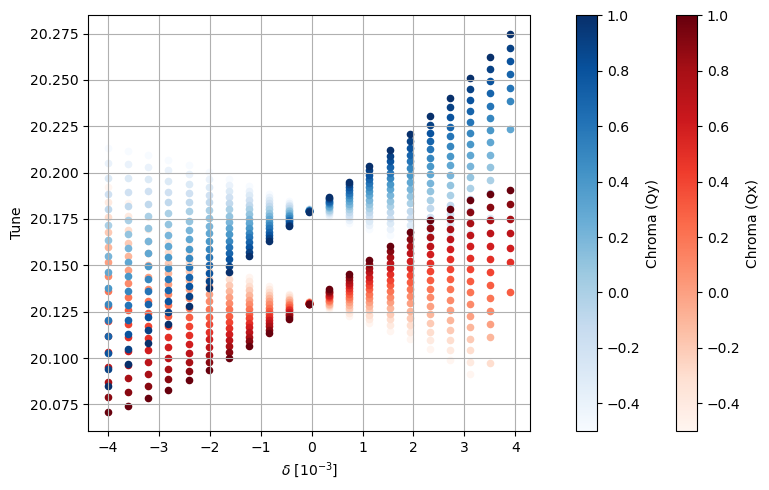

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    tunes_x = []
    tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            tunes_x.append(twiss.qx)
            tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        tunes_x,
        color=cmap_qx(norm(c)),
        s=20
    )

    ax.scatter(
        deltas_tune_plot * 1e3,
        tunes_y,
        color=cmap_qy(norm(c)),
        s=20
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('Tune')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx)')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qy)')

fig.tight_layout()
plt.savefig("Figures/tune_vs_delta.png")


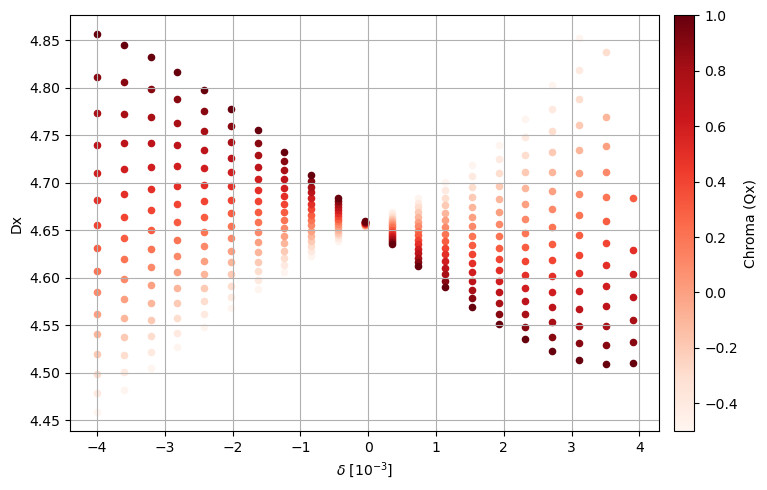

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].dx[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=20
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('Dx')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx)')

# sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
# sm_qy.set_array([])
# cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
# cbar_qy.set_label('Chroma (Qy)')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


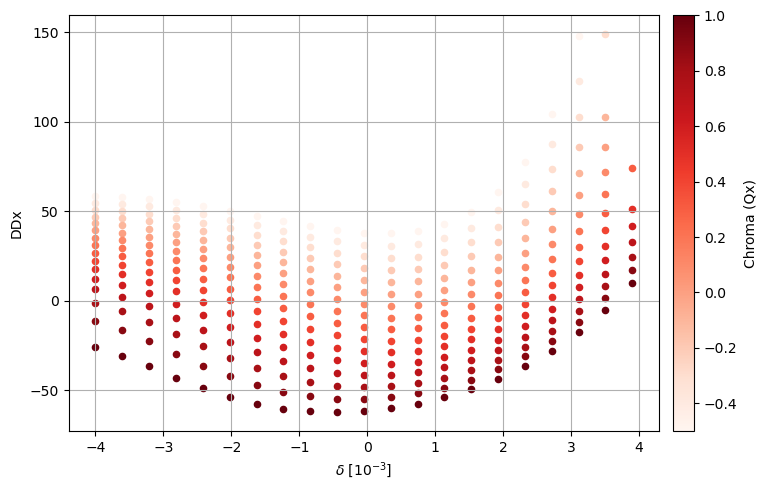

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].ddx[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=20
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('DDx')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx)')

# sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
# sm_qy.set_array([])
# cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
# cbar_qy.set_label('Chroma (Qy)')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


In [88]:
- 4.85 * 0.005 - 25/2 * 0.005**2

-0.024562499999999998

In [89]:
4.51 * 0.005 + 10/2 * 0.005**2

0.022675

In [90]:
- 4.78 * 0.005  + 20/2 * 0.005**2

-0.02365

In [91]:
4.64 * 0.005 + 50/2 * 0.005**2

0.023825

# Line without errors

In [92]:
line_lin = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env_lin = line_lin.env

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [93]:
twissesH_lin = {}

In [94]:
for c in chromas_norm:
    print(f"Processing chroma normalization: {c}")
    twissesH_lin[c] = {}
    dqx_calc = c * qx
    dqy_calc = c * qy
    opt = line.match(
        method='6d', # <- passed to twiss
        vary=[
            xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
            xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
        ],
        targets = [
            xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
            xt.TargetSet(dqx=dqx_calc, dqy=dqy_calc, tol=1e-2, tag='chrom'),
        ])
    
    # try:
    #     twisses0[c] = line.twiss4d()
    # except Exception as err:
    #     twisses0[c] = repr(err)
    for d in deltas:
        try:
            twissesH_lin[c][d] = line.twiss4d(delta0=d)
        except Exception as err:
            twissesH_lin[c][d] = repr(err)

Processing chroma normalization: -0.5
                                             
Optimize - start penalty: 42.76                             
Matching: model call n. 13 penalty = 8.9456e-06              
Optimize - end penalty:  8.94557e-06                            


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




Could not find point within tolerance.


Warning! Need second attempt on closed orbit search
Processing chroma normalization: -0.4
                                             
Optimize - start penalty: 2.85                              
Matching: model call n. 7 penalty = 1.4471e-03              
Optimize - end penalty:  0.00144715                            


Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.




Could not find point within tolerance.


Warning! Need second attempt on closed orbit

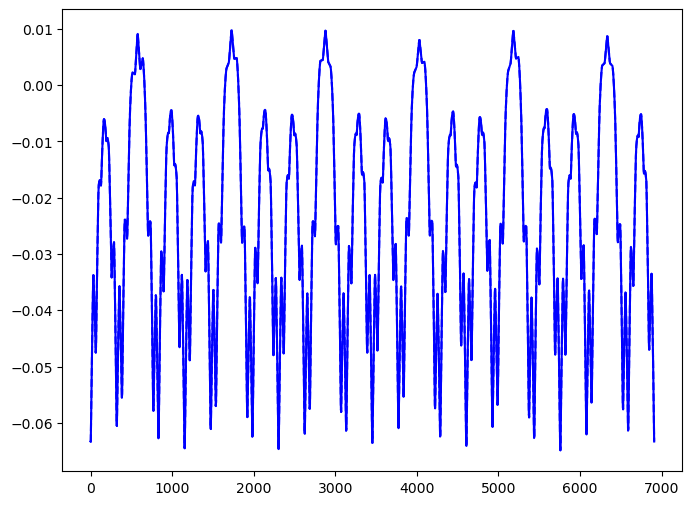

In [108]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

colors = {0.5 : 'blue', 0.7 : 'green', 1.0 : 'red'}
# for c in [0.5, 0.7, 1.0]:
for c in [0.5]:
    tw_pos = twissesH_lin[c][0.0039]
    tw_neg = twissesH_lin[c][-0.004]

    # ax.plot(tw_pos.s, tw_pos.x + tw_pos.dx * 0.0039 + 1/2 * tw_pos.ddx * 0.0039**2, color=colors[c])
    ax.plot(tw_neg.s, tw_neg.x + tw_neg.dx * -0.004 + 1/2 * tw_neg.ddx * (-0.004)**2, color=colors[c])

    tw_pos = twissesH[c][0.0039]
    tw_neg = twissesH[c][-0.004]
    # ax.plot(tw_pos.s, tw_pos.x + tw_pos.dx * 0.0039 + 1/2 * tw_pos.ddx * 0.0039**2, color=colors[c], ls = '--')
    ax.plot(tw_neg.s, tw_neg.x + tw_neg.dx * -0.004 + 1/2 * tw_neg.ddx * (-0.004)**2, color=colors[c], ls = '--')

In [95]:
c = 0.5
twissesH[c].keys()

dict_keys([np.float64(-0.004), np.float64(-0.003605), np.float64(-0.00321), np.float64(-0.002815), np.float64(-0.00242), np.float64(-0.002025), np.float64(-0.0016299999999999995), np.float64(-0.0012349999999999996), np.float64(-0.0008399999999999996), np.float64(-0.00044499999999999965), np.float64(-4.99999999999997e-05), np.float64(0.0003450000000000007), np.float64(0.0007400000000000011), np.float64(0.0011350000000000006), np.float64(0.001530000000000001), np.float64(0.0019250000000000005), np.float64(0.002320000000000001), np.float64(0.0027150000000000013), np.float64(0.003110000000000001), np.float64(0.003505000000000001), np.float64(0.0039)])

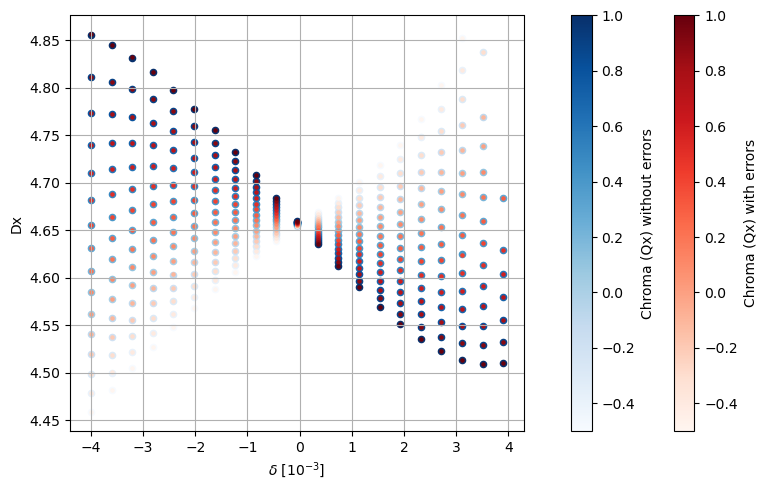

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH_lin[c]:
        twiss = twissesH_lin[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].dx[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qy(norm(c)),
        s=20
    )

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].dx[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=5
    )
ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('Dx')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx) with errors')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qx) without errors')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


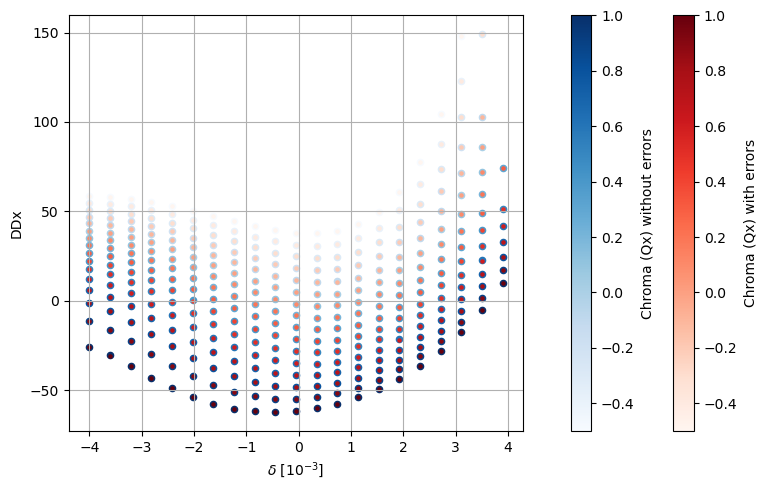

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH_lin[c]:
        twiss = twissesH_lin[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].ddx[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qy(norm(c)),
        s=20
    )

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].ddx[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=5
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('DDx')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx) with errors')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qx) without errors')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


Errors:
0.5 -0.004 -0.0373315151106942
0.5 -0.003605 -0.03370018021432813
0.5 -0.00321 -0.030053552618958226
0.5 -0.002815 -0.02638775840240946
0.5 -0.00242 -0.022702524173739216
0.5 -0.002025 -0.019000868028233402
0.5 -0.0016299999999999995 -0.015288335011135567
0.5 -0.0012349999999999996 -0.011571909885768214
0.5 -0.0008399999999999996 -0.007858822263171111
0.5 -0.00044499999999999965 -0.004155485400048867
0.5 -4.99999999999997e-05 -0.00046670666026476203
0.5 0.0003450000000000007 0.0032048106327941845
0.5 0.0007400000000000011 0.006858746970215284
0.5 0.0011350000000000006 0.010497342760189923
0.5 0.001530000000000001 0.014125587950464839
0.5 0.0019250000000000005 0.017751531848912545
0.5 0.002320000000000001 0.02138682434612018
0.5 0.0027150000000000013 0.025047636008016162
0.5 0.003110000000000001 0.02875625312386354
0.5 0.003505000000000001 0.03254387792319232
0.5 0.0039 0.03645590655988796
0.7 -0.004 -0.0377733746782019
0.7 -0.003605 -0.03407010870926859
0.7 -0.00321 -0.03035511

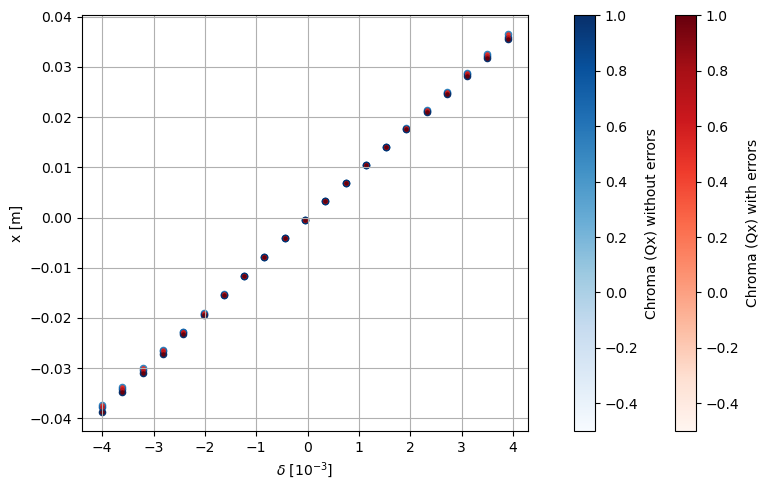

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

print('Errors:')
# for c in chromas_norm:
for c in [0.5, 0.7, 1.0]:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH_lin[c]:
        twiss = twissesH_lin[c][d]
        if type(twiss) != str:
            print(c, d, twiss.rows['qd.31110'].x[0] + twiss.rows['qd.31110'].dx[0] * d + 1/2 * twiss.rows['qd.31110'].ddx[0] * d**2)
            dxs.append(twiss.rows['qd.31110'].x[0] + twiss.rows['qd.31110'].dx[0] * d + 1/2 * twiss.rows['qd.31110'].ddx[0] * d**2)
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qy(norm(c)),
        s=20
    )

# for c in chromas_norm:
print('Linear')
for c in [0.5, 0.7, 1.0]:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            print(c, d, twiss.rows['qd.31110'].x[0] + twiss.rows['qd.31110'].dx[0] * d + 1/2 * twiss.rows['qd.31110'].ddx[0] * d**2)
            dxs.append(twiss.rows['qd.31110'].x[0] + twiss.rows['qd.31110'].dx[0] * d + 1/2 * twiss.rows['qd.31110'].ddx[0] * d**2)
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=5
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('x [m]')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx) with errors')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qx) without errors')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


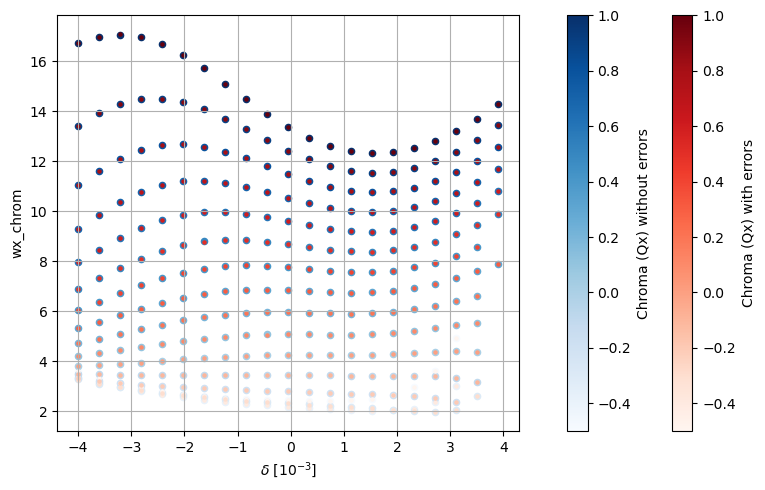

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH_lin[c]:
        twiss = twissesH_lin[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].wx_chrom[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qy(norm(c)),
        s=20
    )

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].wx_chrom[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=5
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('wx_chrom')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx) with errors')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qx) without errors')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


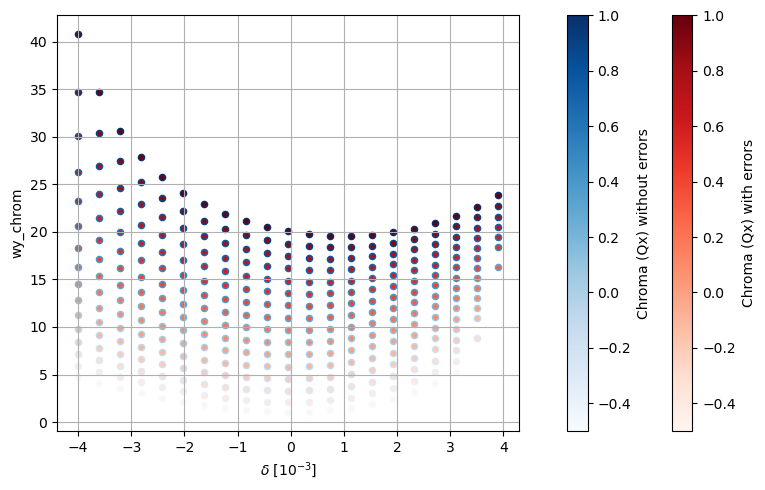

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH_lin[c]:
        twiss = twissesH_lin[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].wy_chrom[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qy(norm(c)),
        s=20
    )

for c in chromas_norm:
    dxs = []
    # tunes_y = []
    deltas_tune_plot = []
    for d in twissesH[c]:
        twiss = twissesH[c][d]
        if type(twiss) != str:
            dxs.append(twiss.rows['qd.31110'].wy_chrom[0])
            # tunes_y.append(twiss.qy)
            deltas_tune_plot.append(d)

    deltas_tune_plot = np.array(deltas_tune_plot)
    ax.scatter(
        deltas_tune_plot * 1e3,
        dxs,
        color=cmap_qx(norm(c)),
        s=5
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('wy_chrom')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx) with errors')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qx) without errors')

fig.tight_layout()
# plt.savefig("Figures/tune_vs_delta.png")


In [115]:
twiss.wx_chrom

array([21.31866892, 21.31866892, 21.31866892, ..., 21.31868547,
       21.31868547, 21.31868547], shape=(32539,))

In [121]:
?line.twiss

Signature:
line.twiss(
    particle_ref=None,
    method=None,
    particle_on_co=None,
    R_matrix=None,
    W_matrix=None,
    delta0=None,
    zeta0=None,
    zeta_shift=None,
    r_sigma=None,
    nemitt_x=None,
    nemitt_y=None,
    delta_disp=None,
    delta_chrom=None,
    zeta_disp=None,
    co_guess=None,
    steps_r_matrix=None,
    co_search_settings=None,
    at_elements=None,
    at_s=None,
    continue_on_closed_orbit_error=None,
    freeze_longitudinal=None,
    freeze_energy=None,
    values_at_element_exit=None,
    radiation_method=None,
    eneloss_and_damping=None,
    radiation_integrals=None,
    start=None,
    end=None,
    init=None,
    num_turns=None,
    skip_global_quantities=None,
    matrix_responsiveness_tol=None,
    matrix_stability_tol=None,
    symplectify=None,
    reverse=None,
    use_full_inverse=None,
    strengths=None,
    hide_thin_groups=None,
    search_for_t_rev=None,
    num_turns_search_t_rev=None,
    only_twiss_init=None,
    only_ma